In [9]:
import os
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
ROOT_DIR

'c:\\Users\\PC\\Desktop\\Weather_Prediction_by_Transfromer'

In [3]:
DATA_FILE_PATH = os.path.join(ROOT_DIR, 'data')

In [4]:
import xarray as xr

temperature_file_path = os.path.join(DATA_FILE_PATH, '2m_temperature.nc')
ds = xr.open_dataset(temperature_file_path)
ds

<xarray.Dataset> Size: 18GB
Dimensions:     (valid_time: 4384, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 35kB 2023-01-01 ... 2025-12-31T18...
    expver      (valid_time) <U4 70kB ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 18GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-06T14:19 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
ram_size_gb = ds.nbytes / (1024**3)
print(f"RAM_SIZE: {ram_size_gb:.4f} GB")

RAM_SIZE: 16.9563 GB


In [6]:
ds = xr.open_dataset(temperature_file_path, chunks={'valid_time': 100})
ram_size_gb = ds.nbytes / (1024**3)
print(f"RAM_SIZE: {ram_size_gb:.4f} GB")

RAM_SIZE: 16.9563 GB


C:\Users\PC\AppData\Local\Temp\ipykernel_4100\2934694705.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(temperature_file_path, chunks={'valid_time': 100})


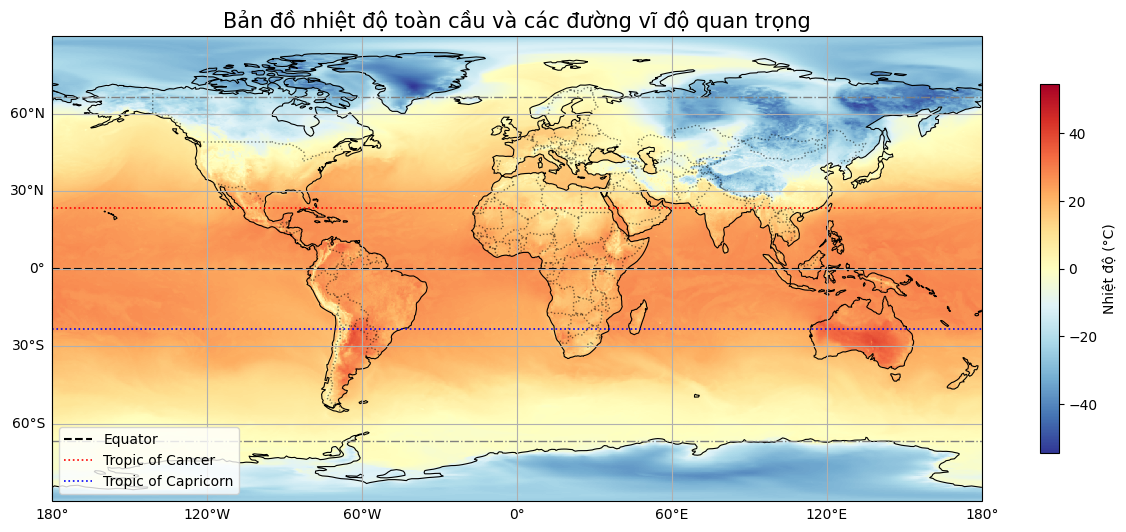

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
temp_c = ds['t2m'].isel(valid_time=0) - 273.15

# 2. Khởi tạo hình ảnh với phép chiếu (Projection)
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree()) # Phép chiếu phẳng phổ biến

# 3. Vẽ dữ liệu nhiệt độ
mesh = temp_c.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap='RdYlBu_r', add_colorbar=True,
    cbar_kwargs={'label': 'Nhiệt độ (°C)', 'shrink': 0.6}
)

# 4. Vẽ các đường đặc biệt
# Vẽ đường Xích đạo (Vĩ độ 0)
ax.axhline(0, color='black', linestyle='--', linewidth=1.5, label='Equator')

# Vẽ Chí tuyến Bắc (23.43° N) và Chí tuyến Nam (23.43° S)
ax.axhline(23.43, color='red', linestyle=':', linewidth=1.2, label='Tropic of Cancer')
ax.axhline(-23.43, color='blue', linestyle=':', linewidth=1.2, label='Tropic of Capricorn')

# Vẽ các đường Vòng cực (Tùy chọn)
ax.axhline(66.57, color='gray', linestyle='-.', linewidth=1)
ax.axhline(-66.57, color='gray', linestyle='-.', linewidth=1)

# 5. Thêm chi tiết bản đồ (Bờ biển, biên giới)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)

# 6. Hiển thị lưới tọa độ
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

plt.title("Bản đồ nhiệt độ toàn cầu và các đường vĩ độ quan trọng", fontsize=15)
plt.legend(loc='lower left')
plt.show()

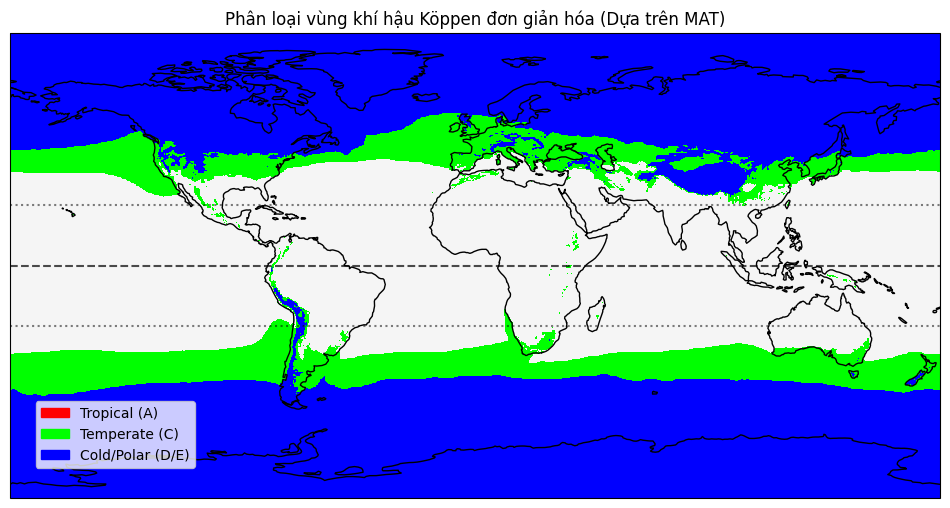

In [16]:
import matplotlib.colors as mcolors
# 2. Hàm phân loại Köppen đơn giản (Ví dụ logic)

mat = (ds['t2m'].mean(dim='valid_time') - 273.15).compute()
def classify_koppen(temp):
    # Khởi tạo mảng cùng hình dạng với temp, mặc định là 0 (Unknown)
    koppen = np.zeros_like(temp)
    
    # Nhóm A: Nhiệt đới
    koppen = np.where(temp > 18, 1, koppen)
    # Nhóm C: Ôn đới
    koppen = np.where((temp <= 18) & (temp > 10), 2, koppen)
    # Nhóm D/E: Lạnh/Cực
    koppen = np.where(temp <= 10, 3, koppen)
    
    return koppen

# Áp dụng phân loại lên toàn bộ grid
koppen_map = koppen_map = xr.apply_ufunc(
    classify_koppen, 
    mat,
    dask='parallelized',
    output_dtypes=[float] # Cần chỉ định kiểu dữ liệu đầu ra khi dùng dask
)

# 3. Định nghĩa bảng màu chuẩn Köppen
# A: Đỏ/Hồng, B: Vàng, C: Xanh lá, D: Tím, E: Xám
colors = ['#f5f5f5', '#ff0000', '#00ff00', '#0000ff'] 
cmap = mcolors.ListedColormap(colors)
labels = {0: 'Unknown', 1: 'Tropical (A)', 2: 'Temperate (C)', 3: 'Cold/Polar (D/E)'}

# 4. Vẽ bản đồ
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Vẽ vùng khí hậu
im = koppen_map.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, add_colorbar=False
)

# Thêm đường Xích đạo và Chí tuyến để đối chiếu
ax.axhline(0, color='black', linestyle='--', alpha=0.7)
ax.axhline(23.43, color='black', linestyle=':', alpha=0.5)
ax.axhline(-23.43, color='black', linestyle=':', alpha=0.5)

# Tạo chú thích (Legend) thủ công
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(1, 4)]
plt.legend(handles=patches, loc='lower left', bbox_to_anchor=(0.02, 0.05))

plt.title("Phân loại vùng khí hậu Köppen đơn giản hóa (Dựa trên MAT)")
plt.show()

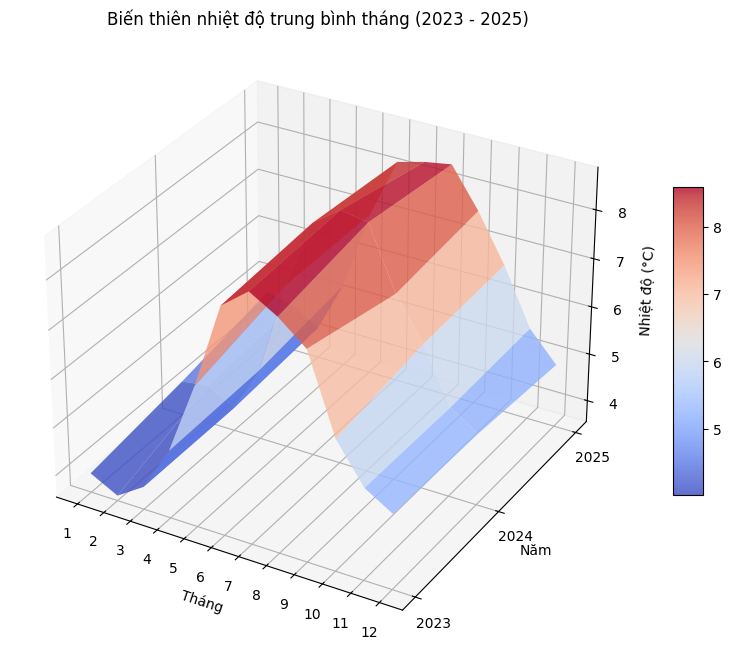

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 2. Tính trung bình theo tháng và theo khu vực
# Chuyển đổi nhiệt độ trung bình của toàn bộ vùng không gian (lat, lon)
# Sau đó tính trung bình theo từng tháng (Resample 'MS' = Month Start)
monthly_avg = ds['t2m'].mean(dim=['latitude', 'longitude']).resample(valid_time='MS').mean()

# Chuyển sang độ C
monthly_temp = monthly_avg.values - 273.15

# 3. Chuẩn bị dữ liệu cho trục X (Tháng), Y (Năm)
years = [2023, 2024, 2025]
months = np.arange(1, 13)
X, Y = np.meshgrid(months, years)

# Chuyển mảng nhiệt độ thành ma trận (3 năm x 12 tháng)
# Lưu ý: Đảm bảo dữ liệu đầu vào đủ 36 tháng
Z = monthly_temp.reshape(3, 12)

# 4. Vẽ biểu đồ 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ bề mặt (Surface plot)
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', edgecolor='none', alpha=0.8)

# Thêm nhãn và tùy chỉnh
ax.set_xlabel('Tháng')
ax.set_ylabel('Năm')
ax.set_zlabel('Nhiệt độ (°C)')
ax.set_title('Biến thiên nhiệt độ trung bình tháng (2023 - 2025)')

# Điều chỉnh các nấc (ticks) cho trục năm và tháng
ax.set_xticks(months)
ax.set_yticks(years)

# Thêm thanh màu (Color bar)
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()